In [1]:
import pandas as pd
import numpy as np
from unified_functions import plot_roc, plot_confusion_matrix, discrimination_threshold
from sklearn.metrics import roc_curve, roc_auc_score

pd.options.display.max_columns = None

/home/np/PUT/V semester/AI/microscopic-epe-proj/.venv/lib/python3.13/site-packages/dalex/_global_checks.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
data = pd.read_csv('../materials/processed_df_new.csv')

In [3]:
data_cores = pd.read_excel('../materials/baza zanonimizowana UZUPEŁNIONA.xlsx')
data_cores.drop(313, inplace=True) # STUMP in Bx ISUP
data_cores['Bx ISUP Grade'] = data_cores[['Bx ISUP Grade L', 'Bx ISUP Grade P']].max(axis=1)

# MSKCC nomograms
https://www.mskcc.org/nomograms/prostate/pre_op/coefficients


Legend of Symbols:\
$\beta_0$: Intercept term, denoted by “Intercept” \
$\beta_{(variable \space name)}$: Coefficient estimate, associated with a covariate/variable \
$\gamma$: Scaling parameter in survival regression models, denoted by “Scaling Parameter” \
$X\beta$: Model linear predictor, estimated by summation of the intercept term and all $\beta$ values multiplied by that variable. For example, $\beta_0 + \beta_{var1} * var1 + \beta_{var2} * var2 + … \beta_{varN} * varN$

Logistic regression models are used to predict probabilities. The prediction is estimated by:
$$
prediceted \space probability = \frac{e^{X\beta}}{1 + e^{X\beta}}
$$

In [12]:
# MSKCC coefficients
coefficients = {
    'EPE': {
        'intercept': -4.3619472,
        'age': 0.02789286,
        'psa': 0.25391759,
        'psa_spline_1': -0.00185119,
        'psa_spline_2': 0.00512636,
        'biopsy_gleason': {
            2: 0.9456123,
            3: 1.38600414,
            4: 1.47229518,
            5: 2.52672521
        },
        'clinical_stage': {
            '2a': 0.29223705,
            '2b': 0.8045909,
            '2c': 0.85209752,
            '3plus': 1.67265063
        }
    },

    'EPE cores': {
        'intercept': -4.14615912,
        'age': 0.03263727,
        'psa': 0.22419499,
        'psa_spline_1': -0.00151357,
        'psa_spline_2': 0.0041806,
        'biopsy_gleason': {
            2: 0.62975509,
            3: 1.04483516,
            4: 1.11988728,
            5: 2.04021401
        },
        'clinical_stage': {
            '2a': 0.21016394,
            '2b': 0.7631916,
            '2c': 0.56884638,
            '3plus': 1.46007476
        },
        'no_positive_cores': 0.08760181,
        'no_negative_cores': -0.06353104
    },

    'N+': {
        'intercept': -5.83057151,
        'age': 0.00521158,
        'psa': 0.18754729,
        'psa_spline_1': -0.00122617,
        'psa_spline_2': 0.0033653,
        'biopsy_gleason': {
            2: 1.52752948,
            3: 2.57873595,
            4: 2.75375893,
            5: 3.50034615
        },
        'clinical_stage': {
            '2a': 0.26172062,
            '2b': 0.55860494,
            '2c': 0.84874365,
            '3plus': 1.09527926
        }
    },

    'N+ cores': {
        'intercept': -5.37408605,
        'age': 0.01061319,
        'psa': 0.22266602,
        'psa_spline_1': -0.001599,
        'psa_spline_2': 0.00441175,
        'biopsy_gleason': {
            2: 0.998897,
            3: 2.03362879,
            4: 2.177025,
            5: 2.87515732
        },
        'clinical_stage': {
            '2a': 0.17084652,
            '2b': 0.49919005,
            '2c': 0.46102494,
            '3plus': 0.74403104
        },
        'no_positive_cores': 0.05972006,
        'no_negative_cores': -0.09466818
    },

    'SVI': {
        'intercept': -5.96514874,
        'age': 0.01303056,
        'psa': 0.16554996,
        'psa_spline_1': -0.00095842,
        'psa_spline_2': 0.00262538,
        'biopsy_gleason': {
            2: 1.24764853,
            3: 2.04455038,
            4: 2.19455366,
            5: 3.17089909
        },
        'clinical_stage': {
            '2a': 0.28661144,
            '2b': 0.58408599,
            '2c': 1.04372486,
            '3plus': 1.23384554
        }
    },

    'SVI cores': {
        'intercept': -6.11427809,
        'age': 0.02483733,
        'psa': 0.1475095,
        'psa_spline_1': -0.00085465,
        'psa_spline_2': 0.00234133,
        'biopsy_gleason': {
            2: 1.11283762,
            3: 1.89864418,
            4: 2.06573755,
            5: 2.97808178
        },
        'clinical_stage': {
            '2a': 0.13563953,
            '2b': 0.43790414,
            '2c': 0.67764059,
            '3plus': 0.80895957
        },
        'no_positive_cores': 0.07682603,
        'no_negative_cores': -0.10972019
    }
}

### Helper functions

In [13]:
PSAPreopKnot1 = 0.2
PSAPreopKnot2 = 4.8
PSAPreopKnot3 = 7.35
PSAPreopKnot4 = 307.0

def calculate_splines(var):
    psa_spline_1 = max(var - PSAPreopKnot1, 0) ** 3 - max(var - PSAPreopKnot3, 0) ** 3 * (PSAPreopKnot4 - PSAPreopKnot1) / (PSAPreopKnot4 - PSAPreopKnot3) + max(var - PSAPreopKnot4, 0) ** 3 * (PSAPreopKnot3 - PSAPreopKnot1) / (PSAPreopKnot4 - PSAPreopKnot3)
    psa_spline_2 = max(var - PSAPreopKnot2, 0) ** 3 - max(var - PSAPreopKnot3, 0) ** 3 * (PSAPreopKnot4 - PSAPreopKnot2) / (PSAPreopKnot4 - PSAPreopKnot3) + max(var - PSAPreopKnot4, 0) ** 3 * (PSAPreopKnot3 - PSAPreopKnot2) / (PSAPreopKnot4 - PSAPreopKnot3)
    return psa_spline_1, psa_spline_2

In [14]:
def stage(tnm, stage_weights):
    tnm = tnm.lower()
    if 't2a' in tnm: return stage_weights['2a']
    if 't2b' in tnm: return stage_weights['2b']
    if 't2c' in tnm: return stage_weights['2c']
    if 't3' in tnm or 't4' in tnm: return stage_weights['3plus']
    return 0.0

In [15]:
def gleason(isup, gleason_weights):
    if isup == 2: return gleason_weights[2]
    if isup == 3: return gleason_weights[3]
    if isup == 4: return gleason_weights[4]
    if isup == 5: return gleason_weights[5]
    return 0.0

In [16]:
def getCores(patient):
    cores_P = patient['ilość\xa0+ wycinków P']
    if cores_P == 0:
        pos_P = 0
        neg_P = 0
    else:
        cores_P = cores_P.split('na')
        pos_P = int(cores_P[0])
        neg_P = int(cores_P[1]) - pos_P

    cores_L = patient['Ilość + wycinków L']
    if cores_L == 0:
        pos_L = 0
        neg_L = 0
    else:
        cores_L = cores_L.split('na')
        pos_L = int(cores_L[0])
        neg_L = int(cores_L[1]) - pos_L

    return pos_P + pos_L, neg_P + neg_L

In [17]:
def mskcc_predict(patient, target='N+'):
    psa_spline_1, psa_spline_2 = calculate_splines(patient['PSA'])

    b = coefficients[target]['intercept'] + \
        coefficients[target]['age'] * patient['wiek'] + \
        coefficients[target]['psa'] * patient['PSA'] + \
        coefficients[target]['psa_spline_1'] * psa_spline_1 + \
        coefficients[target]['psa_spline_2'] * psa_spline_2 + \
        gleason(patient['Bx ISUP Grade'], coefficients[target]['biopsy_gleason']) + \
        stage(patient['TNM'], coefficients[target]['clinical_stage'])

    if 'cores' in target:
        pos_cores, neg_cores = getCores(patient)
        b += coefficients[target]['no_positive_cores'] * pos_cores + \
             coefficients[target]['no_negative_cores'] * neg_cores
    
    return np.exp(b) / (1 + np.exp(b))

### EPE

Number of patients: 400
AUC: 0.83410426


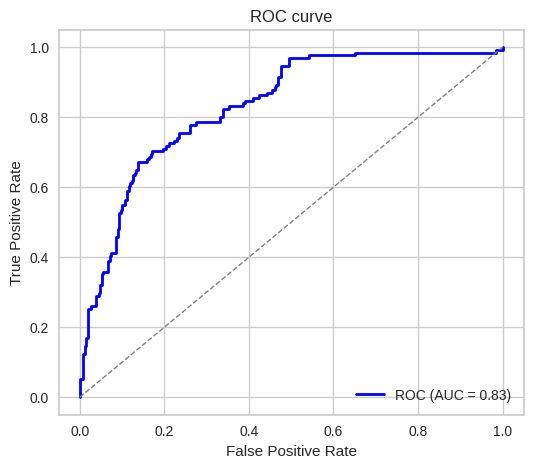

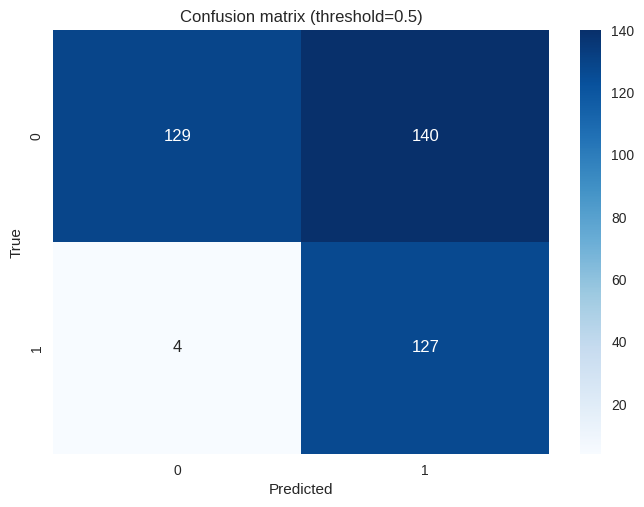

Sensitivity: 0.9695
Specificity: 0.4796
Accuracy: 0.6400

Threshold optimized for F1 score:


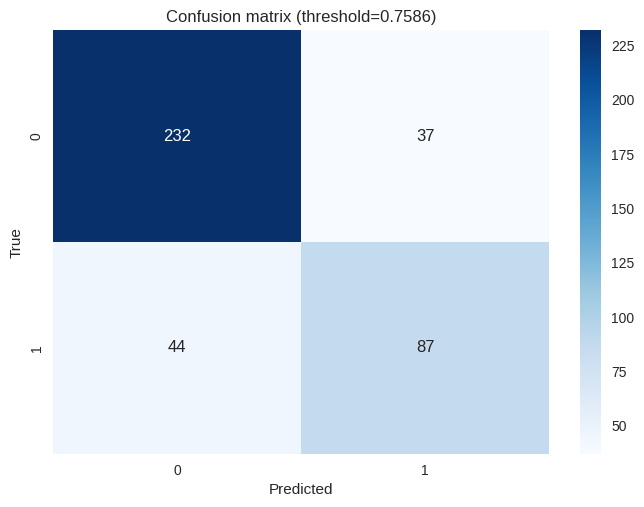

Sensitivity: 0.6641
Specificity: 0.8625
Accuracy: 0.7975

Threshold optimized for accuracy:


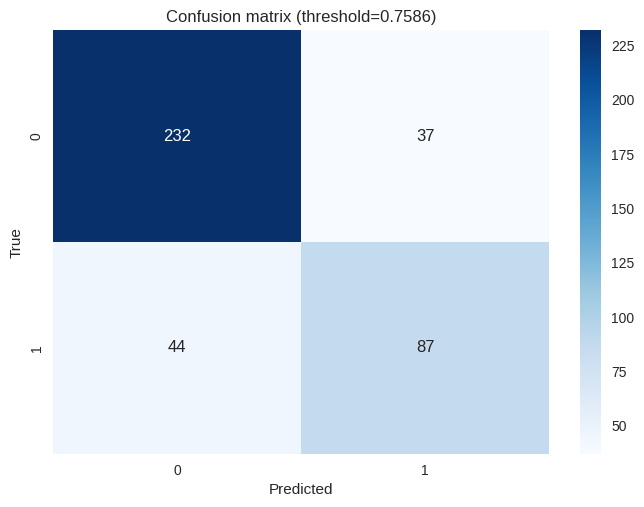

Sensitivity: 0.6641
Specificity: 0.8625
Accuracy: 0.7975


In [18]:
data_epe = data.dropna(subset=['wiek', 'PSA', 'Bx ISUP Grade', 'TNM', 'EPE RP'])
print(f"Number of patients: {data_epe.shape[0]}")

for idx, patient in data_epe.iterrows():
    prob = mskcc_predict(patient, target='EPE')
    data_epe.loc[idx, 'EPE pred prob'] = prob
    data_epe.loc[idx, 'EPE pred'] = prob > 0.5

y_true = data_epe['EPE RP']
y_pred_prob = data_epe['EPE pred prob']
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
auc = roc_auc_score(y_true, y_pred_prob)
print(f"AUC: {auc:.8f}")

plot_roc(fpr, tpr, auc)
plot_confusion_matrix(y_true, y_pred_probs=y_pred_prob, threshold=0.5)

print("\nThreshold optimized for F1 score:")
plot_confusion_matrix(y_true, y_pred_probs=y_pred_prob, threshold=np.round(discrimination_threshold(y_true, y_pred_prob), 4))
print("\nThreshold optimized for accuracy:")
plot_confusion_matrix(y_true, y_pred_probs=y_pred_prob, threshold=np.round(discrimination_threshold(y_true, y_pred_prob, method='accuracy'), 4))

Predict EPE with cores

Number of patients: 100
AUC: 0.85962302


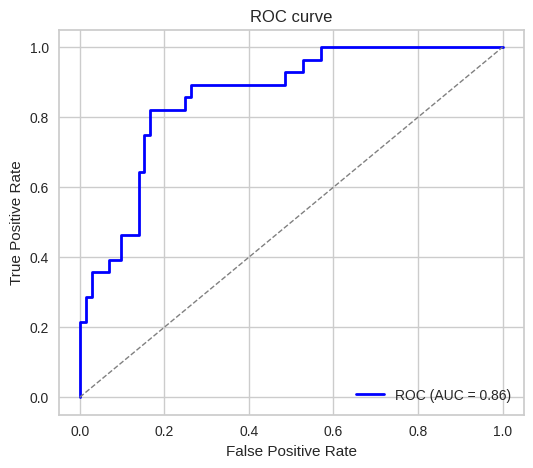

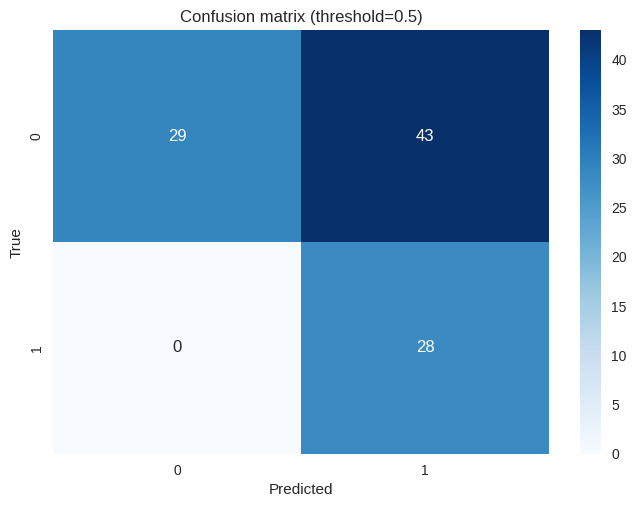

Sensitivity: 1.0000
Specificity: 0.4028
Accuracy: 0.5700

Threshold optimized for F1 score:


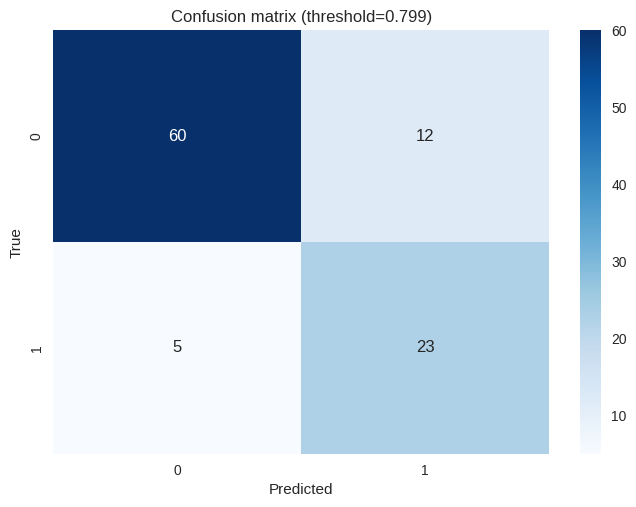

Sensitivity: 0.8214
Specificity: 0.8333
Accuracy: 0.8300

Threshold optimized for accuracy:


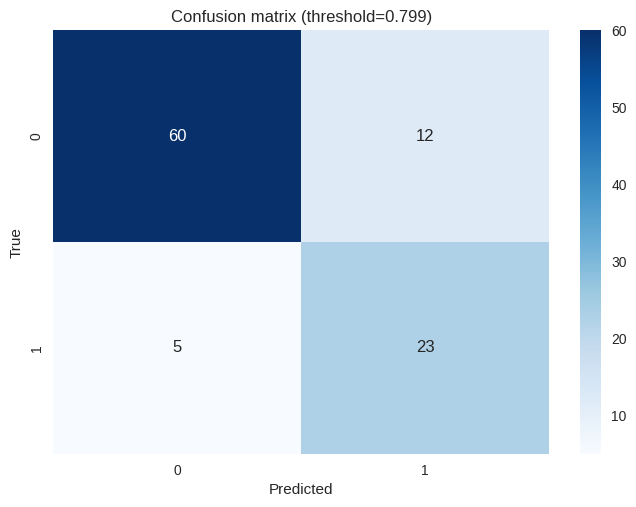

Sensitivity: 0.8214
Specificity: 0.8333
Accuracy: 0.8300


In [19]:
data_epe_cores = data_cores.dropna(subset=['wiek', 'PSA', 'Bx ISUP Grade', 'ilość\xa0+ wycinków P', 'Ilość + wycinków L', 'TNM', 'EPE RP'])
print(f"Number of patients: {data_epe_cores.shape[0]}")

for idx, patient in data_epe_cores.iterrows():
    prob = mskcc_predict(patient, target='EPE cores')
    data_epe_cores.loc[idx, 'EPE cores pred prob'] = prob
    data_epe_cores.loc[idx, 'EPE cores pred'] = prob > 0.5

y_true = data_epe_cores['EPE RP']
y_pred_prob = data_epe_cores['EPE cores pred prob']
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
auc = roc_auc_score(y_true, y_pred_prob)
print(f"AUC: {auc:.8f}")

plot_roc(fpr, tpr, auc)
plot_confusion_matrix(y_true, y_pred_probs=y_pred_prob, threshold=0.5)

print("\nThreshold optimized for F1 score:")
plot_confusion_matrix(y_true, y_pred_probs=y_pred_prob, threshold=np.round(discrimination_threshold(y_true, y_pred_prob), 4))
print("\nThreshold optimized for accuracy:")
plot_confusion_matrix(y_true, y_pred_probs=y_pred_prob, threshold=np.round(discrimination_threshold(y_true, y_pred_prob, method='accuracy'), 4))

Results for predicting EPE (AUC):
- without cores:
  - MSKCC: 0.75
  - our data: 0.83
  - our model: 0.80
  
- with cores:
  - MSKCC: 0.78
  - our data: 0.86

### Nodal Involvment

Number of patients: 400
AUC: 0.83192789


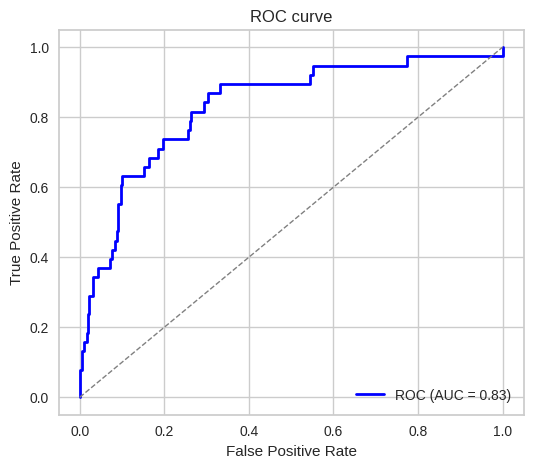

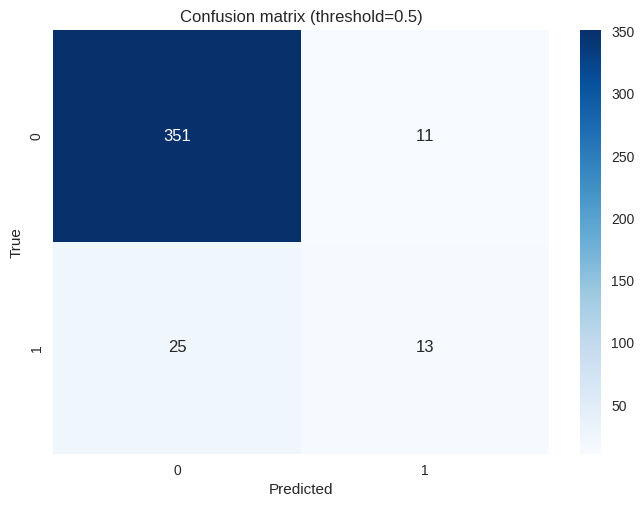

Sensitivity: 0.3421
Specificity: 0.9696
Accuracy: 0.9100

Threshold optimized for F1 score:


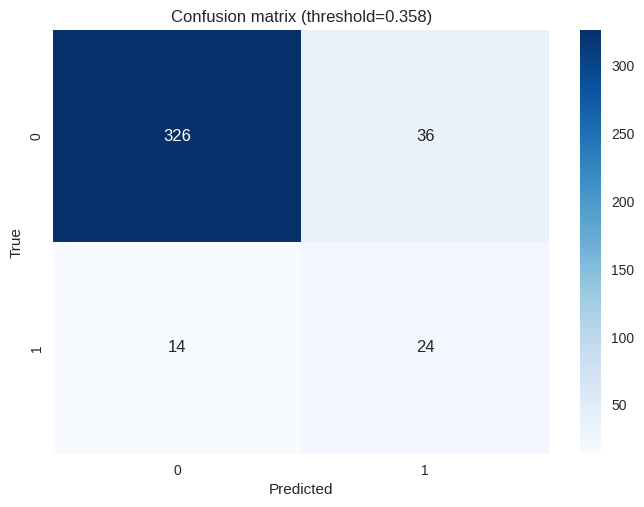

Sensitivity: 0.6316
Specificity: 0.9006
Accuracy: 0.8750

Threshold optimized for accuracy:


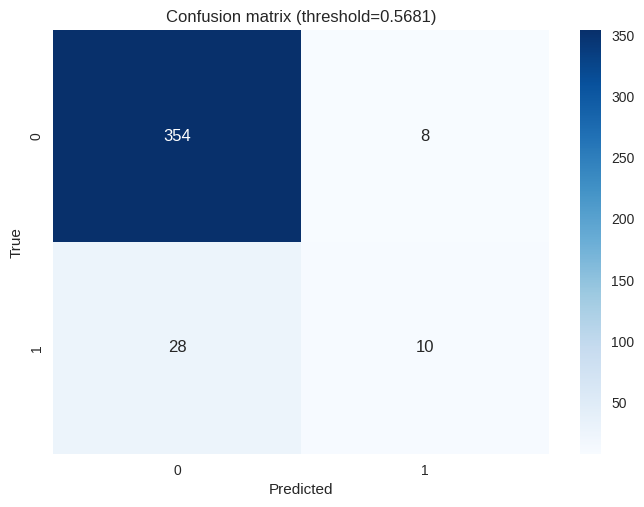

Sensitivity: 0.2632
Specificity: 0.9779
Accuracy: 0.9100


In [20]:
data_nplus= data.dropna(subset=['wiek', 'PSA', 'Bx ISUP Grade', 'TNM', 'N +'])
print(f"Number of patients: {data_nplus.shape[0]}")

for idx, patient in data_nplus.iterrows():
    prob = mskcc_predict(patient, target='N+')
    data_nplus.loc[idx, 'N+ pred prob'] = prob
    data_nplus.loc[idx, 'N+ pred'] = prob > 0.5

y_true = data_nplus['N +']
y_pred_prob = data_nplus['N+ pred prob']
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
auc = roc_auc_score(y_true, y_pred_prob)
print(f"AUC: {auc:.8f}")

plot_roc(fpr, tpr, auc)
plot_confusion_matrix(y_true, y_pred_probs=y_pred_prob, threshold=0.5)

print("\nThreshold optimized for F1 score:")
plot_confusion_matrix(y_true, y_pred_probs=y_pred_prob, threshold=np.round(discrimination_threshold(y_true, y_pred_prob), 4))
print("\nThreshold optimized for accuracy:")
plot_confusion_matrix(y_true, y_pred_probs=y_pred_prob, threshold=np.round(discrimination_threshold(y_true, y_pred_prob, method='accuracy'), 4))

N+ prediction with cores

Number of patients: 101
AUC: 0.87252747


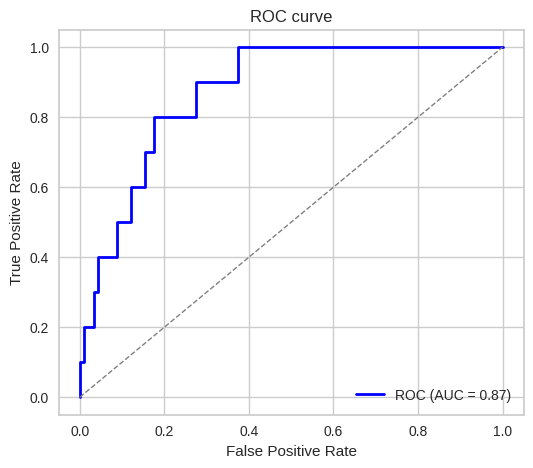

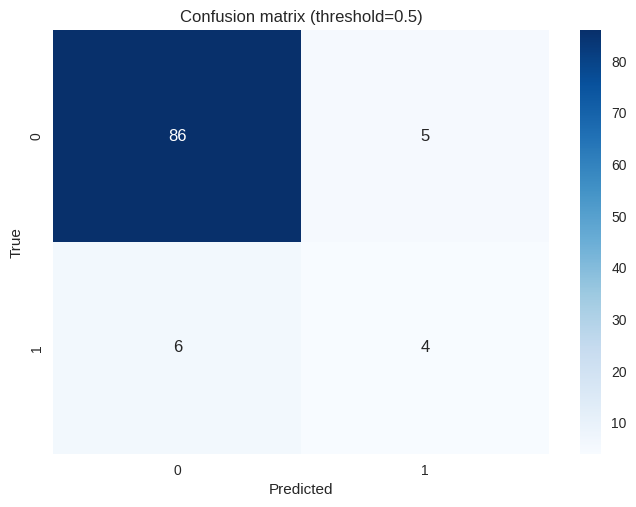

Sensitivity: 0.4000
Specificity: 0.9451
Accuracy: 0.8911

Threshold optimized for F1 score:


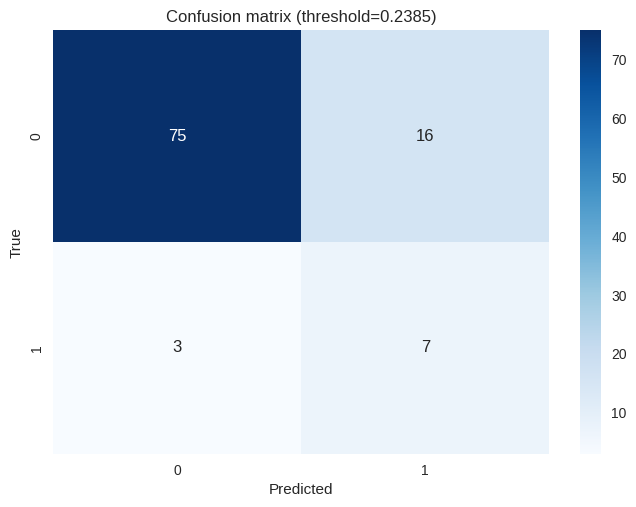

Sensitivity: 0.7000
Specificity: 0.8242
Accuracy: 0.8119

Threshold optimized for accuracy:


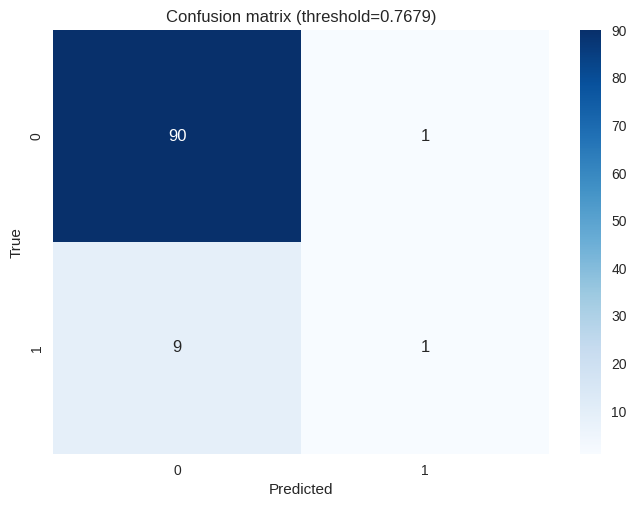

Sensitivity: 0.1000
Specificity: 0.9890
Accuracy: 0.9010


In [21]:
data_nplus_cores = data_cores.dropna(subset=['wiek', 'PSA', 'Bx ISUP Grade', 'ilość\xa0+ wycinków P', 'Ilość + wycinków L', 'TNM', 'N +'])
print(f"Number of patients: {data_nplus_cores.shape[0]}")

for idx, patient in data_nplus_cores.iterrows():
    prob = mskcc_predict(patient, target='N+ cores')
    data_nplus_cores.loc[idx, 'N+ cores pred prob'] = prob
    data_nplus_cores.loc[idx, 'N+ cores pred'] = prob > 0.5
y_true = data_nplus_cores['N +']
y_pred_prob = data_nplus_cores['N+ cores pred prob']
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
auc = roc_auc_score(y_true, y_pred_prob)
print(f"AUC: {auc:.8f}")

plot_roc(fpr, tpr, auc)
plot_confusion_matrix(y_true, y_pred_probs=y_pred_prob, threshold=0.5)

print("\nThreshold optimized for F1 score:")
plot_confusion_matrix(y_true, y_pred_probs=y_pred_prob, threshold=np.round(discrimination_threshold(y_true, y_pred_prob), 4))
print("\nThreshold optimized for accuracy:")
plot_confusion_matrix(y_true, y_pred_probs=y_pred_prob, threshold=np.round(discrimination_threshold(y_true, y_pred_prob, method='accuracy'), 4))

Results for predicting N+ (AUC):
- without cores:
  - MSKCC: 0.83
  - our data: 0.83
  - our model: 0.87
- with cores:
  - MSKCC: 0.84
  - our data: 0.87

### SVI

Number of patients: 400
AUC: 0.75625035


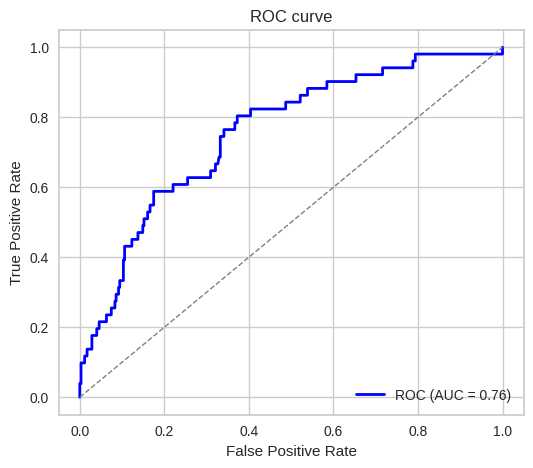

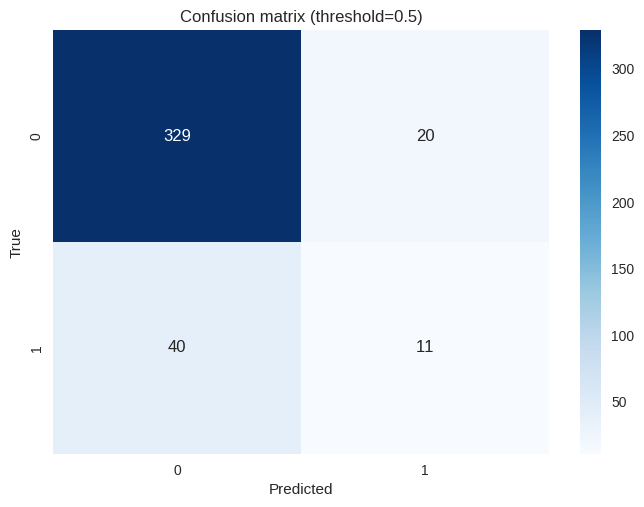

Sensitivity: 0.2157
Specificity: 0.9427
Accuracy: 0.8500

Threshold optimized for F1 score:


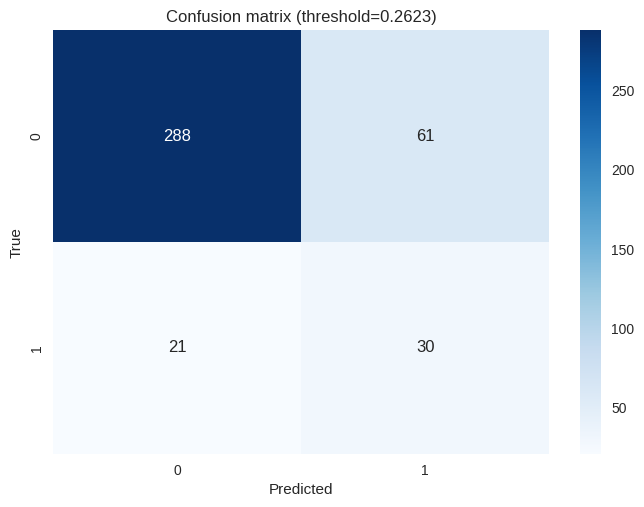

Sensitivity: 0.5882
Specificity: 0.8252
Accuracy: 0.7950

Threshold optimized for accuracy:


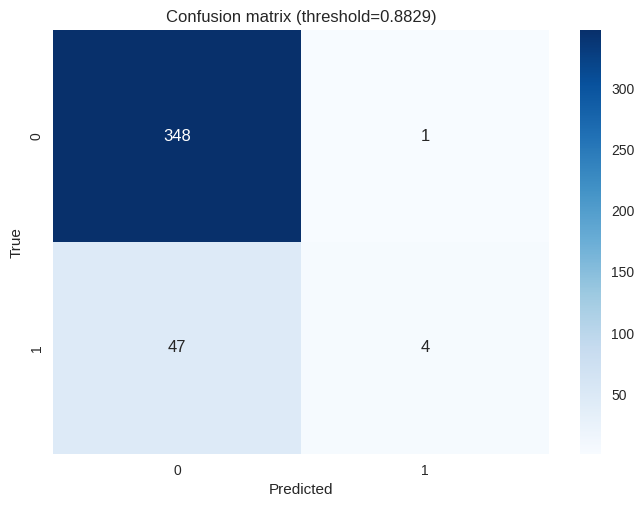

Sensitivity: 0.0784
Specificity: 0.9971
Accuracy: 0.8800


In [22]:
data_svi = data.dropna(subset=['wiek', 'PSA', 'Bx ISUP Grade', 'TNM', 'SVI RP'])
print(f"Number of patients: {data_svi.shape[0]}")

for idx, patient in data_svi.iterrows():
    prob = mskcc_predict(patient, target='SVI')
    data_svi.loc[idx, 'SVI pred prob'] = prob
    data_svi.loc[idx, 'SVI pred'] = prob > 0.5
y_true = data_svi['SVI RP']
y_pred_prob = data_svi['SVI pred prob']
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
auc = roc_auc_score(y_true, y_pred_prob)
print(f"AUC: {auc:.8f}")

plot_roc(fpr, tpr, auc)
plot_confusion_matrix(y_true, y_pred_probs=y_pred_prob, threshold=0.5)

print("\nThreshold optimized for F1 score:")
plot_confusion_matrix(y_true, y_pred_probs=y_pred_prob, threshold=np.round(discrimination_threshold(y_true, y_pred_prob), 4))
print("\nThreshold optimized for accuracy:")
plot_confusion_matrix(y_true, y_pred_probs=y_pred_prob, threshold=np.round(discrimination_threshold(y_true, y_pred_prob, method='accuracy'), 4))

SVI prediction with cores

Number of patients: 100


AUC: 0.71059783


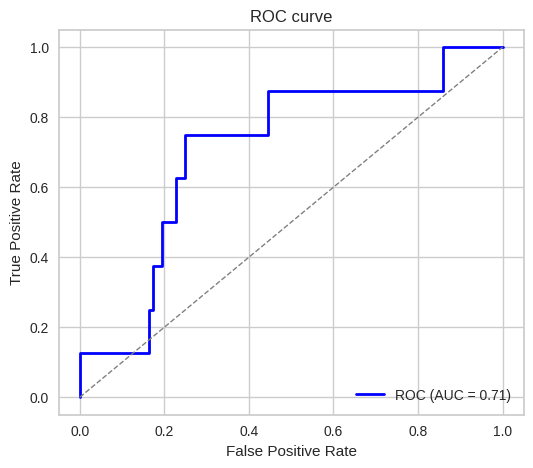

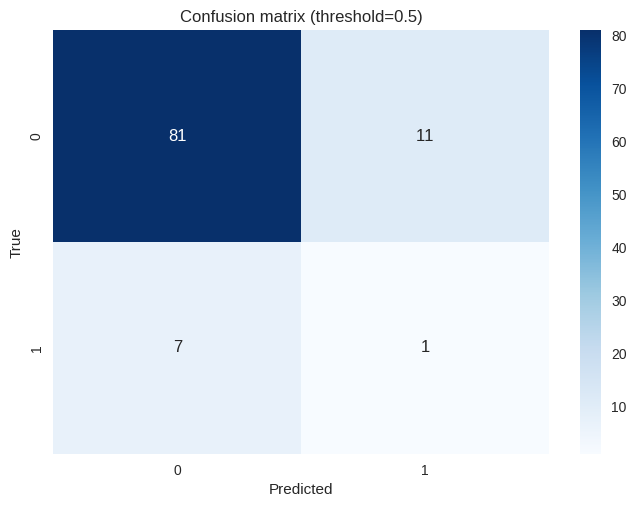

Sensitivity: 0.1250
Specificity: 0.8804
Accuracy: 0.8200

Threshold optimized for F1 score:


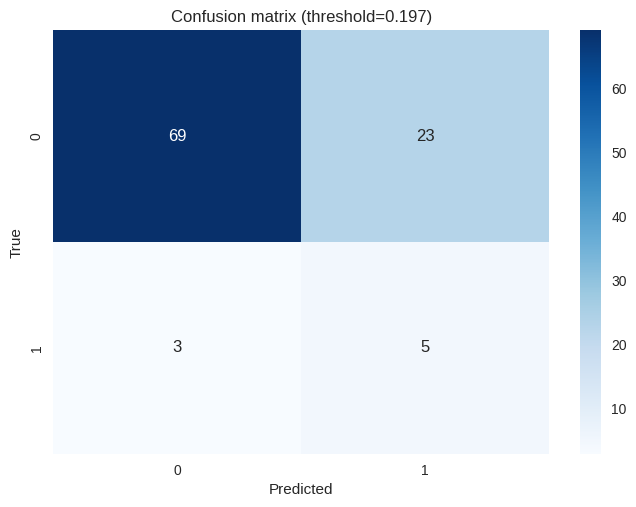

Sensitivity: 0.6250
Specificity: 0.7500
Accuracy: 0.7400

Threshold optimized for accuracy:


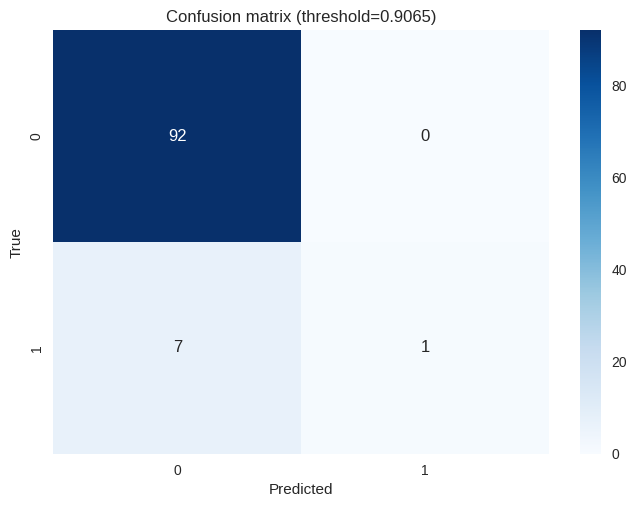

Sensitivity: 0.1250
Specificity: 1.0000
Accuracy: 0.9300


In [23]:
data_svi_cores = data_cores.dropna(subset=['wiek', 'PSA', 'Bx ISUP Grade', 'ilość\xa0+ wycinków P', 'Ilość + wycinków L', 'TNM', 'SVI RP'])
print(f"Number of patients: {data_svi_cores.shape[0]}")

for idx, patient in data_svi_cores.iterrows():
    prob = mskcc_predict(patient, target='SVI cores')
    data_svi_cores.loc[idx, 'SVI cores pred prob'] = prob
    data_svi_cores.loc[idx, 'SVI cores pred'] = prob > 0.5
y_true = data_svi_cores['SVI RP']
y_pred_prob = data_svi_cores['SVI cores pred prob']
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
auc = roc_auc_score(y_true, y_pred_prob)
print(f"AUC: {auc:.8f}")

plot_roc(fpr, tpr, auc)
plot_confusion_matrix(y_true, y_pred_probs=y_pred_prob, threshold=0.5)

print("\nThreshold optimized for F1 score:")
plot_confusion_matrix(y_true, y_pred_probs=y_pred_prob, threshold=np.round(discrimination_threshold(y_true, y_pred_prob), 4))
print("\nThreshold optimized for accuracy:")
plot_confusion_matrix(y_true, y_pred_probs=y_pred_prob, threshold=np.round(discrimination_threshold(y_true, y_pred_prob, method='accuracy'), 4))

Results for predicting SVI (AUC):
- without cores:
  - MSKCC: 0.82
  - our data: 0.76
  - our model: 0.69
- with cores:
  - MSKCC: 0.85
  - our data: 0.71

# Summary

<table>
  <tr>
    <th colspan=5>Porównanie AUC nomogramów MSKCC i naszego modelu</th>
  </tr>
  <tr>
    <th>Przewidywana kolumna</th>
    <th>Wycinki z biopsji (tak/nie)</th>
    <th>MSKCC</th>
    <th>MSKCC nasze dane</th>
    <th>Nasz model</th>
  </tr>
  <tr>
    <td rowspan=2>EPE</td>
    <td>Nie</td>
    <td>0.75</td>
    <td>0.83</td>
    <td>0.80</td>
  </tr>
  <tr>
    <td>Tak</td>
    <td>0.78</td>
    <td>0.86</td>
    <td></td>
  </tr>
  <tr>
    <td rowspan=2>N+</td>
    <td>Nie</td>
    <td>0.83</td>
    <td>0.83</td>
    <td>0.87</td>
  </tr>
  <tr>
    <td>Tak</td>
    <td>0.84</td>
    <td>0.87</td>
    <td></td>
  </tr>
  <tr>
    <td rowspan=2>SVI</td>
    <td>Nie</td>
    <td>0.82</td>
    <td>0.76</td>
    <td>0.69</td>
  </tr>
  <tr>
    <td>Tak</td>
    <td>0.85</td>
    <td>0.71</td>
    <td></td>
  </tr>
</table>